In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn import linear_model 
from sklearn.ensemble import RandomForestRegressor


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

plt.rcParams['figure.figsize']=(16,6)

#### Определение вспомогательных функций

In [2]:
def mean_absolute_percentage_error(reg, X, y): 
    return np.mean(np.abs((y - reg.predict(X)) / y)) * 100

In [156]:
def evaluate_model(reg, data, features, cv=5, transform_method=None, plot=False):
        
    print("Количество признаков: {}".format(len(features)))
    #transform data
    
    if transform_method:
        data = pd.concat([pd.DataFrame(transform_method.fit_transform(data[(features)]), index=data[features].index, columns=features),
                          data['price_usa']], axis=1)

    if plot:
        X_train, X_test, y_train, y_test = train_test_split(data[features], data['price_usa'], test_size=0.33, random_state=42)
        reg.fit(X_train, y_train)
        predictions = reg.predict(X_test)
        predictions_sorted = reg.predict(X_test.loc[y_test.sort_values().index.values])
        
        print("Mean Absolute Error: {:.4f}".format(mean_absolute_error(y_test, predictions)))
        print("Mean absolute percentage error: {:.4f}".format(mean_absolute_percentage_error(reg, X_test, y_test)))
        print()
        print("Mean Squared Error: {:.4f}".format(mean_squared_error(y_test, predictions)))
        print("R2 score: {:.4f}\n".format(r2_score(y_test, predictions)))
    
        plt.plot(sorted(y_test), c='r')
        #plt.plot(sorted(y_test)+np.std(y_test))
        #plt.plot(sorted(y_test)-np.std(y_test))
        plt.scatter(range(len(y_test)), predictions_sorted, s=1.7)
        #plt.plot(predictions_sorted)
        plt.xlabel('sorted index')
        plt.ylabel('price usa')
        plt.grid()
        
        return reg

    # MAE
    cross_scores = cross_val_score(reg, data[features], data['price_usa'], scoring='neg_mean_absolute_error', cv=cv)
    #print(cross_scores, end='')
    print("Mean (MAE) CV {}-fold: {:.4f}".format(cv, -np.mean(cross_scores)))
    #print("std (MAE) CV {}-fold: {:.4f}\n".format(cv, np.std(cross_scores)))
    
    # MAPE
    cross_scores = cross_val_score(reg, data[features], data['price_usa'], scoring=mean_absolute_percentage_error, cv=cv)
    #print(cross_scores)
    print("Mean (MAPE) CV {}-fold: {:.4f}".format(cv, np.mean(cross_scores)))
    #print("std (MAPE) CV {}-fold: {:.4f}\n".format(cv, np.std(cross_scores)))
    
    
    #RMSLE
    cross_scores = cross_val_score(reg, data[features], data['price_usa'], scoring='neg_mean_squared_log_error', cv=cv)
    #print(cross_scores)
    print("Mean (RMSLE) CV {}-fold: {:.4f}".format(cv, -np.mean(cross_scores)))
    #print("std (RMSLE) CV {}-fold: {:.4f}\n".format(cv, np.std(cross_scores)))
    
    print()
    # R2
    cv = StratifiedKFold(cv, random_state=42)
    cross_scores = cross_val_score(reg, data[features], data['price_usa'], scoring='r2', cv=cv)
    #print(cross_scores)
    print("Mean (R2) CV {}-fold: {:.4f}".format(cv.get_n_splits(), np.mean(cross_scores)))
    #print("std (R2) CV {}-fold: {:.4f}".format(cv.get_n_splits(), np.std(cross_scores)))

### Загрузка

In [4]:
#realt = pd.read_csv('../data/realt_lite_final.csv')
realt = pd.read_csv('../data/realt_2712_13-30.csv')

In [5]:
realt.isnull().sum(axis=0)

address                  0
code                     0
description           1232
floor                    0
latitude                 0
longitude                0
photos                   0
price_local              0
price_usa                0
views_day                0
views_week               0
zones                    0
Агентство                0
Балкон                   0
Бытовая техника        329
Год постройки            0
Дата обновления          0
Дополнительно          503
Мебель                   0
Метро                    0
Планировка               0
Плита                    0
Полы                   387
Примечания            1042
Район города             0
Ремонт                   0
Сан/узел                 0
Соседи по квартире       0
Телефон                  0
Тип дома                 0
rooms                    0
total_area               0
living_area              0
kitchen_area             0
floors                   0
plan_proc                0
panel_type               0
p

### Добавление признаков

#### Элитность

In [6]:
dum_tech = realt['Бытовая техника'].str.get_dummies(sep=', ')
dum_dop = realt['Дополнительно'].str.get_dummies(sep=', ')
elite_features = ['VIP-квартира',
                  'элитная квартира',
                  'консьержка',
                  'видеодомофон',
                  'сигнализация',
                  'посудомоечная машина',
                  'домашний кинотеатр',
                  'душевая кабина',
                  'джакузи',
                  'подземный гараж',
                  'охраняемая территория',
                  'гараж',
                  'кондиционер']
#data['VIP-квартира'] = data[['VIP-квартира', 'элитная квартира']].sum(axis=1).clip(0, 1)
realt['elite'] = pd.concat([dum_tech, dum_dop], axis=1)[elite_features].sum(axis=1)
realt[['elite', 'price_usa']].corr()

,elite,price_usa
elite,1.00000,0.51353
price_usa,0.51353,1.00000


#### Кодирование микрорайонов средней ценой

\begin{equation*}
\frac{mean(y)*K + glob.mean(y)*\alpha}{K + \alpha}
\end{equation*}

In [7]:
glob_mean = realt['price_usa'].mean()
stat_table = realt.groupby('zones').price_usa.agg(('mean', 'min', 'max', 'count')).reset_index()
alpha = 10

for i in realt.index:
    group_mean = stat_table.loc[stat_table['zones'] == realt.loc[i, 'zones'], 'mean'].values[0]
    group_count = stat_table.loc[stat_table['zones'] == realt.loc[i, 'zones'], 'count'].values[0]
    realt.loc[i, 'zones_proc'] = (group_mean*group_count + glob_mean*alpha)/(group_count + alpha)

In [8]:
pd.merge(realt.groupby('zones')['zones_proc'].agg(('mean', 'count')).reset_index(), 
         realt.groupby('zones')['price_usa'].agg(('mean', 'count')).reset_index(),
         on='zones').head()[['zones', 'count_x', 'mean_x', 'mean_y', ]]

,zones,count_x,mean_x,mean_y
0,Ангарская,26,320.143058,224.615385
1,"Аэродромная, Могилевская, Воронянского",62,419.474307,395.435484
2,"Багратиона, Менделеева, Уральская, Столетова",16,510.275003,473.875000
3,"Богдановича, Куйбышева, Веры Хоружей",102,608.233483,612.127451
4,Боровая,1,549.195462,356.000000


#### Расстояние до метро

In [9]:
realt.head(1)

,address,code,description,floor,latitude,longitude,photos,price_local,price_usa,views_day,views_week,zones,Агентство,Балкон,Бытовая техника,Год постройки,Дата обновления,Дополнительно,Мебель,Метро,Планировка,Плита,Полы,Примечания,Район города,Ремонт,Сан/узел,Соседи по квартире,Телефон,Тип дома,rooms,total_area,living_area,kitchen_area,floors,plan_proc,panel_type,photos_proc,Ближайшее метро,До метро,До центра,elite,zones_proc
0,"Минск, Логойский тракт",1217100,NaN,3,53.94964,27.615829,3.0,356,180,19,19,Восток,0,1,холодильник,2003.571429,2017-12-27,"металлическая дверь, стеклопакеты, окна во двор",1,нет,Пропуск,1,NaN,"Сдается 1-квартира в Зеленом Луге, по Логойско...",Первомайский район,0,1,нет,1,Пропуск,1,33.0,18.0,9.0,9,1.0,0,3.0,Маскоўская,2536.316747,6346.702407,0,481.764132


In [12]:
# Если квартира в радиусе 1000 метров от метро -> 1
realt['dometro_proc'] = realt['До метро'].apply(lambda dist: 1 if dist < 1000 else 0)

### Модель

In [13]:
realt.head(1)

,address,code,description,floor,latitude,longitude,photos,price_local,price_usa,views_day,views_week,zones,Агентство,Балкон,Бытовая техника,Год постройки,Дата обновления,Дополнительно,Мебель,Метро,Планировка,Плита,Полы,Примечания,Район города,Ремонт,Сан/узел,Соседи по квартире,Телефон,Тип дома,rooms,total_area,living_area,kitchen_area,floors,plan_proc,panel_type,photos_proc,Ближайшее метро,До метро,До центра,elite,zones_proc,dometro_proc
0,"Минск, Логойский тракт",1217100,NaN,3,53.94964,27.615829,3.0,356,180,19,19,Восток,0,1,холодильник,2003.571429,2017-12-27,"металлическая дверь, стеклопакеты, окна во двор",1,нет,Пропуск,1,NaN,"Сдается 1-квартира в Зеленом Луге, по Логойско...",Первомайский район,0,1,нет,1,Пропуск,1,33.0,18.0,9.0,9,1.0,0,3.0,Маскоўская,2536.316747,6346.702407,0,481.764132,0


In [69]:
features = ['latitude',
            'longitude',
            'zones_proc',
            'floor',
            'photos_proc',
            #'photos',
            'views_day',
            'views_week',
            'Агентство',
            #'Балкон',
            'Мебель',
            'Плита',
            'Сан/узел',
            'Телефон',
            'До метро',
            'rooms',
            #'living_area',
            'kitchen_area',
            'total_area',
            'До центра',
            'elite',
            'Ремонт',
            'floors',
            'Год постройки',
            'dometro_proc',
            'plan_proc',
            'panel_type'
           ]
dum_dist = pd.get_dummies(realt['Район города'])
#dum_tech = realt['Бытовая техника'].str.get_dummies(sep=', ')
#dum_type = pd.get_dummies(realt['Тип дома'])
#dum_plan = pd.get_dummies(realt['Планировка'])
#dum_dist = pd.get_dummies(realt['Район города'])

data = pd.concat([realt,
                  #dum_type,
                  #dum_dist
                 ],axis=1)

                 
features_n = features# + dum_type.columns.values.tolist() + dum_dist.columns.values.tolist()

In [66]:
realt['balcon_proc'] = realt['Балкон'].clip(0, 1)

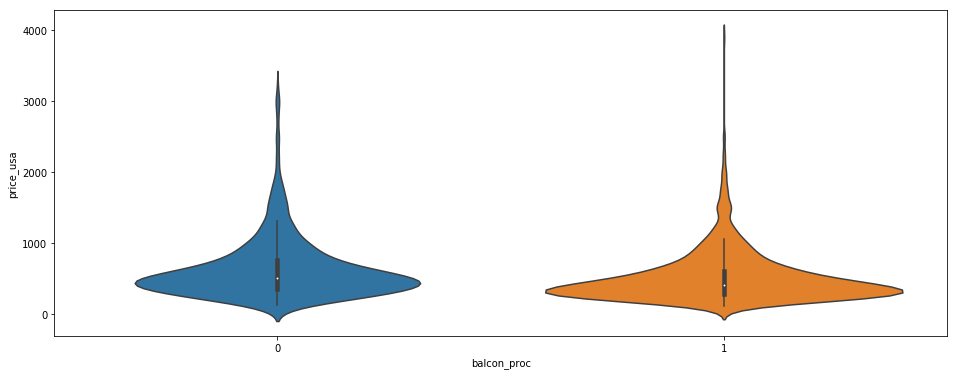

In [71]:
sns.violinplot('balcon_proc', 'price_usa', data=realt)

Количество признаков: 24
Mean Absolute Error: 137.4228
Mean absolute percentage error: 25.1925

Mean Squared Error: 53850.5231
R2 score: 0.6815



Weight?,Feature
+564.946,<BIAS>
+213.107,total_area
+84.794,zones_proc
+33.881,photos_proc
+31.274,elite
+16.174,Ремонт
+9.040,plan_proc
+4.853,dometro_proc
+1.768,Агентство
-3.245,panel_type


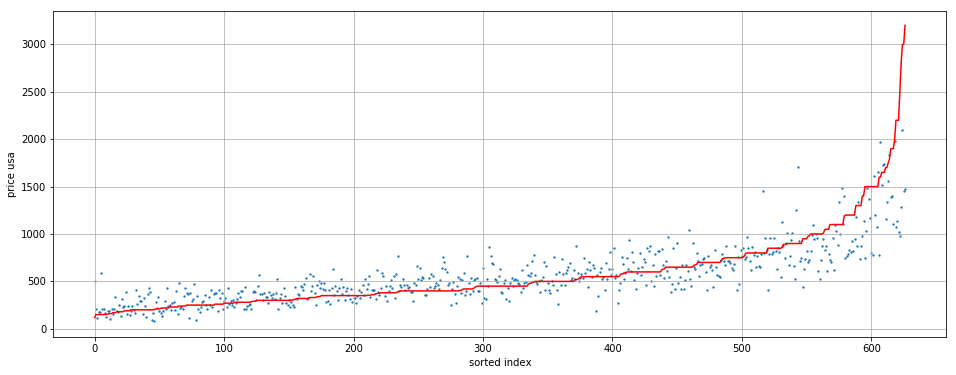

In [76]:
reg = linear_model.Lasso(alpha=20)
transformer = preprocessing.StandardScaler()
reg = evaluate_model(reg, data, features_n, transform_method=transformer, plot=True)


from eli5 import explain_weights
explain_weights(reg, feature_names = features_n, top=40)

In [77]:
evaluate_model(reg, data, features_n, transform_method=transformer)

Количество признаков: 24
Mean (MAE) CV 5-fold: 144.2053
Mean (MAPE) CV 5-fold: 25.6923
Mean (RMSLE) CV 5-fold: 0.0999

Mean (R2) CV 5-fold: 0.6346


In [151]:
final_features = ['total_area',
                  'zones_proc',
                  'elite',
                  'photos_proc',
                  'Ремонт',
                  'plan_proc',
                  'Агентство',
                  'panel_type',
                  'dometro_proc',
                  'views_week',
                  'До центра']
reg = linear_model.Ridge(alpha=19)
evaluate_model(reg, data, final_features, transform_method=transformer)

Количество признаков: 11
Mean (MAE) CV 5-fold: 144.3486
Mean (MAPE) CV 5-fold: 26.8744

Mean (R2) CV 5-fold: 0.6426


In [162]:
transformer = preprocessing.StandardScaler()
data = pd.concat([pd.DataFrame(transformer.fit_transform(realt[final_features]), index=realt[final_features].index, columns=final_features),
                          data['price_usa']], axis=1)
reg = linear_model.HuberRegressor(alpha=1.2)
reg.fit(data[final_features], data['price_usa'])
predictions = reg.predict(data[final_features])

In [165]:
realt['predictions'] = predictions

In [230]:
reg = linear_model.HuberRegressor()
#reg = linear_model.Ridge(alpha=19)
#reg_n = evaluate_model(reg, data, final_features, transform_method=transformer, plot=True)
evaluate_model(reg, data, final_features, transform_method=transformer)

Количество признаков: 11
Mean (MAE) CV 5-fold: 136.9907
Mean (MAPE) CV 5-fold: 23.3515
Mean (RMSLE) CV 5-fold: 0.1040

Mean (R2) CV 5-fold: 0.6452


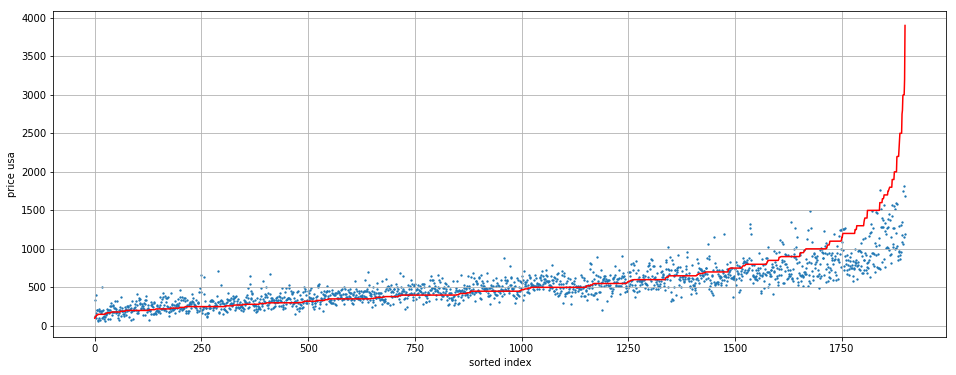

In [231]:
transformer = preprocessing.StandardScaler()
data = pd.concat([pd.DataFrame(transformer.fit_transform(realt[final_features]), index=realt[final_features].index, columns=final_features),
                          data['price_usa']], axis=1)
reg = linear_model.HuberRegressor(alpha=1.5)
#reg = linear_model.Ridge()
reg.fit(data[final_features], data['price_usa'])
predictions = reg.predict(data[final_features])
realt['predictions'] = predictions

plt.plot(realt['price_usa'].sort_values().values, c='r')
#plt.plot(sorted(y_test)+np.std(y_test))
#plt.plot(sorted(y_test)-np.std(y_test))
plt.scatter(range(len(realt)), realt.loc[realt['price_usa'].sort_values().index, 'predictions'].values, s=1.7)
#plt.plot(predictions_sorted)
plt.xlabel('sorted index')
plt.ylabel('price usa')
plt.grid()

In [184]:
realt.head()

,address,code,description,floor,latitude,longitude,photos,price_local,price_usa,views_day,views_week,zones,Агентство,Балкон,Бытовая техника,Год постройки,Дата обновления,Дополнительно,Мебель,Метро,Планировка,Плита,Полы,Примечания,Район города,Ремонт,Сан/узел,Соседи по квартире,Телефон,Тип дома,rooms,total_area,living_area,kitchen_area,floors,plan_proc,panel_type,photos_proc,Ближайшее метро,До метро,До центра,elite,zones_proc,dometro_proc,balcon_proc,predictions
0,"Минск, Логойский тракт",1217100,NaN,3,53.94964,27.615829,3.0,356,180,19,19,Восток,0,1,холодильник,2003.571429,2017-12-27,"металлическая дверь, стеклопакеты, окна во двор",1,нет,Пропуск,1,NaN,"Сдается 1-квартира в Зеленом Луге, по Логойско...",Первомайский район,0,1,нет,1,Пропуск,1,33.0,18.0,9.0,9,1.0,0,3.0,Маскоўская,2536.316747,6346.702407,0,481.764132,0,1,223.193399
1,"Минск, Холмогорский 2-й пер., 2",1216469,NaN,1,53.88820,27.651000,9.0,356,180,33,186,"Дражня, Холмогорская",0,1,"холодильник, стиральная машина, интернет",2011.000000,2017-12-24,"парковка, детская площадка",0,нет,новостройка,0,линолеум,Сдам порядочной семье или молодой паре 1 комна...,Партизанский район,0,1,нет,1,панельный,1,40.0,17.0,9.0,10,1.0,1,9.0,Партызанская,1967.509927,6096.310169,0,533.195462,0,1,246.417416
2,"Минск, Куприянова ул., 19",1215983,NaN,7,53.89800,27.519900,8.0,396,200,18,160,"Р.Люксембург, К.Либкнехта",0,1,интернет,1966.000000,2017-12-22,"металлическая дверь, лифт, окна во двор",0,Молодежная (Заводская линия).,брежневка,0,NaN,1 комнатная квартира на ул.Куприянова. После р...,Московский район,0,1,нет,1,кирпичный,1,31.0,17.0,7.0,9,0.0,0,8.0,Маладзёжная,987.511144,2778.653458,0,489.218425,1,1,219.819719
3,"Минск, Космонавтов ул., 12",1207670,NaN,5,53.85340,27.462500,6.0,435,220,20,182,Малиновка,1,1,"холодильник, свч-печь, стиральная машина, инте...",2013.000000,2017-12-07,"домофон, металлическая дверь, лифт, стеклопаке...",1,Малиновка (Московская линия).,новостройка,1,линолеум,"Сдается однокомнатная квартира в новом доме, е...",Московский район,0,1,нет,1,панельный,1,35.0,18.0,7.0,9,1.0,1,6.0,Малінаўка,898.116976,8499.264096,0,369.387502,1,1,184.864317
4,"Минск, Коласа ул., 50/3",1216085,NaN,1,53.93630,27.606400,7.0,435,220,28,365,"Независимости, Кедышко, Волгоградская",0,1,"холодильник, стиральная машина, душевая кабина...",1962.000000,2017-12-22,"домофон, металлическая дверь, встроенные шкафы...",1,"Парк Челюскинцев, до метро 15 мин. пешком (Мос...",хрущевка,0,ламинат,NaN,Первомайский район,0,1,нет,1,панельный,1,31.0,18.0,7.0,5,0.0,1,7.0,Парк Чалюскінцаў,1426.453349,4781.894640,1,577.619854,0,1,173.711539


In [195]:
realt[['price_usa', 'predictions']].corr()

,price_usa,predictions
price_usa,1.000000,0.830907
predictions,0.830907,1.000000


In [189]:
realt.to_csv('../data/predictions(Huber_1.5).csv', index=False)